Install dependency

> `pip install librosa soundfile pydub numpy scipy scikit-learn matplotlib tensorflow`

In [2]:
! pip install librosa soundfile pydub numpy scipy scikit-learn matplotlib tensorflow

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached audioread-3.1.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-1.0.0-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.2-cp311-cp311-win_amd64.whl.metadata (8.4 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl (1.0 MB)
Using cached audioread-3.1.0-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached msgpack-1.1.2-cp311-cp311-win_amd64.whl (71 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB 435.7 kB/s eta 0:00:07
   - -------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\VICTUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Config & Helper functions (load/save, preprocess)

In [4]:
import os
import numpy as np
import librosa
import soundfile as sf
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils
import matplotlib.pyplot as plt
import random
import sklearn.metrics as skm

# ---------- CONFIG ----------
BASE_PATH = r"C:/Users/VICTUS/Documents/PSD/dataset/augmented_audio"  # output folder containing /buka and /tutup
SAMPLE_RATE = 22050
DURATION = 1.5              # target duration in seconds for each clip (pad/truncate)
SAMPLES = int(SAMPLE_RATE * DURATION)
N_MFCC = 40                 # mfcc count
RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCHS = 30
MODEL_SAVE_PATH = "voice_cnn_model.h5"

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
# ----------------------------

# ---------- HELPERS ----------
def load_audio_file(path, sr=SAMPLE_RATE, target_len=SAMPLES):
    """
    Load audio robustly. Returns mono float32 array at sample rate sr and exact length target_len (pad or trim).
    """
    try:
        # try librosa first (works for wav/mp3 if ffmpeg available)
        y, orig_sr = librosa.load(path, sr=sr, mono=True)
    except Exception:
        # fallback to pydub
        try:
            audio_seg = AudioSegment.from_file(path)
            audio_seg = audio_seg.set_frame_rate(sr).set_channels(1)
            samples = np.array(audio_seg.get_array_of_samples()).astype(np.float32) / (2**15)
            y = samples
        except Exception as e:
            print(f"Failed to load {path}: {e}")
            return None

    # normalize amplitude to -1..1 if needed
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    # pad or truncate to target_len
    if len(y) < target_len:
        pad_width = target_len - len(y)
        y = np.concatenate([y, np.zeros(pad_width, dtype=np.float32)])
    else:
        y = y[:target_len]

    return y.astype(np.float32)

def extract_mfcc_features(y, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=2048, hop_length=512):
    """
    Return MFCC + delta + delta2 as shape (n_mfcc*3, time_frames) or we can return (time_frames, n_features).
    We'll return (n_mfcc, T) then stack deltas -> final shape (n_features, T)
    """
    # compute MFCC (shape: n_mfcc x T)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    # deltas
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # stack: final shape (n_mfcc*3, T)
    feat = np.vstack([mfcc, delta, delta2])
    return feat  # dtype float, shape (n_features, T)

def prepare_feature_array(feature):
    """
    Convert feature (n_features, T) to a fixed 2D map for CNN: we can use resizing or pad to fixed time frames.
    We'll transpose to (T, n_features) and then expand channel axis.
    """
    # transpose
    feat_t = feature.T  # shape (T, n_features)
    # Optionally, enforce fixed shape (T should be consistent because we fixed audio length)
    return feat_t

# Utility to collect files + labels
def collect_files_labels(base_path, classes=['buka','tutup']):
    filepaths, labels = [], []
    for cls in classes:
        folder = os.path.join(base_path, cls)
        if not os.path.exists(folder):
            print("Warning: folder not found:", folder)
            continue
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.wav', '.mp3', '.m4a', '.flac')):
                filepaths.append(os.path.join(folder, fname))
                labels.append(cls)
    return filepaths, labels
# ----------------------------


Build dataset (load, extract features)

In [5]:
# collect
filepaths, labels = collect_files_labels(BASE_PATH, classes=['buka','tutup'])
print(f"Found {len(filepaths)} files")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)   # 0/1 mapping
print("Classes:", list(le.classes_))

# Extract features
features = []   # will hold arrays of shape (T, n_features)
bad_files = []
for i, path in enumerate(filepaths):
    y = load_audio_file(path, sr=SAMPLE_RATE, target_len=SAMPLES)
    if y is None:
        bad_files.append(path)
        continue
    feat = extract_mfcc_features(y, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
    feat_t = prepare_feature_array(feat)  # shape (T, n_features)
    features.append(feat_t)

print(f"Successfully extracted features for {len(features)} / {len(filepaths)} files")
if bad_files:
    print("Bad files:", bad_files)


Found 200 files
Classes: ['buka', 'tutup']
Successfully extracted features for 200 / 200 files


In [6]:
# inspect shape
print("Example feature shape (T, n_features):", features[0].shape)
T, n_features = features[0].shape


Example feature shape (T, n_features): (65, 120)


Convert list → numpy arrays, pad/truncate time dimension if necessary

In [7]:
# find max/min T
Ts = [f.shape[0] for f in features]
print("T min/max:", min(Ts), max(Ts))
# ensure equal T by padding/truncating
TARGET_T = max(Ts)
X = []
for f in features:
    if f.shape[0] < TARGET_T:
        pad = np.zeros((TARGET_T - f.shape[0], f.shape[1]), dtype=np.float32)
        f2 = np.vstack([f, pad])
    else:
        f2 = f[:TARGET_T, :]
    X.append(f2)

X = np.stack(X, axis=0)  # shape (N, T, n_features)
y = np.array(y_encoded[:len(X)])  # align lengths (in case some bad files removed)
print("X shape:", X.shape, "y shape:", y.shape)

# expand channel dim for CNN: (N, T, n_features, 1)
X_cnn = X[..., np.newaxis]
print("X_cnn shape:", X_cnn.shape)


T min/max: 65 65
X shape: (200, 65, 120) y shape: (200,)
X_cnn shape: (200, 65, 120, 1)


Train / Validation / Test split

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X_cnn, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)


Train/Val/Test shapes: (140, 65, 120, 1) (30, 65, 120, 1) (30, 65, 120, 1)


Build CNN model

In [9]:
def build_cnn_model(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)  # (T, n_features, 1)
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train.shape[1:]  # (T, n_features, 1)
n_classes = len(le.classes_)
model = build_cnn_model(input_shape, n_classes)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 120, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 65, 120, 16)       160       
                                                                 
 batch_normalization (Batch  (None, 65, 120, 16)       64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 60, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 60, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 60, 32)        4640  

Train model with callbacks

In [10]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr]
)

# save model
model.save(MODEL_SAVE_PATH)
print("Model saved to", MODEL_SAVE_PATH)


Epoch 1/30
5/5 [==============================] - 2s 171ms/step - loss: 0.7128 - accuracy: 0.5500 - val_loss: 0.6725 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 1s 124ms/step - loss: 0.5841 - accuracy: 0.6786 - val_loss: 0.6439 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 1s 138ms/step - loss: 0.5634 - accuracy: 0.7143 - val_loss: 0.6493 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 1s 115ms/step - loss: 0.5624 - accuracy: 0.7000 - val_loss: 0.6305 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 1s 112ms/step - loss: 0.5055 - accuracy: 0.7571 - val_loss: 0.6208 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 1s 112ms/step - loss: 0.5259 - accuracy: 0.7357 - val_loss: 0.6172 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 1s 110ms/step - loss: 0.4942 - a

C:\Users\VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


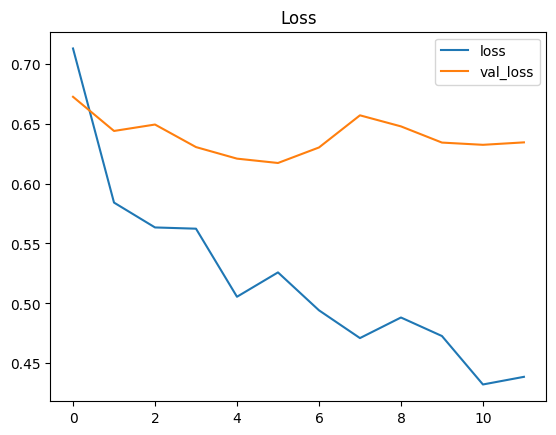

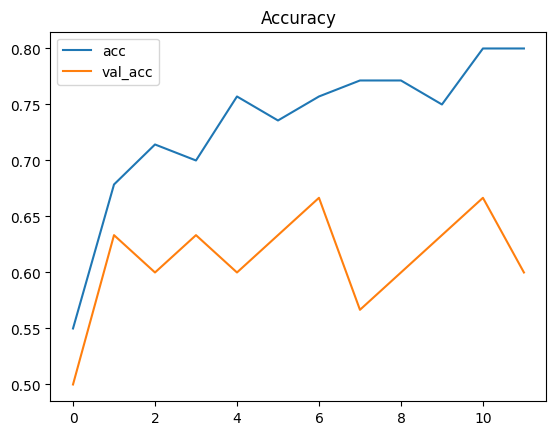

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


Evaluate on test set

1/1 [==============================] - 0s 278ms/step
Test accuracy: 0.7666666666666667
Classification report:
              precision    recall  f1-score   support

        buka       0.83      0.67      0.74        15
       tutup       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30

Confusion matrix:
 [[10  5]
 [ 2 13]]


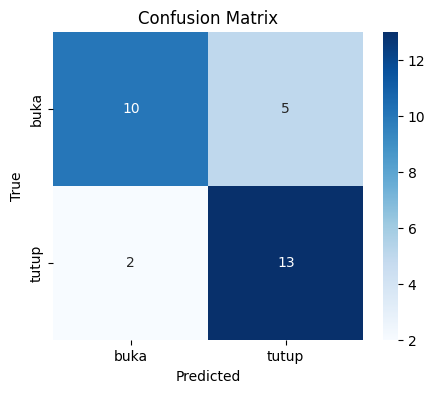

In [12]:
# predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = np.mean(y_pred == y_test)
print("Test accuracy:", acc)

# classification report
print("Classification report:")
print(skm.classification_report(y_test, y_pred, target_names=le.classes_))

# confusion matrix
cm = skm.confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# plot confusion matrix (optional)
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


Predict function for a new audio file (detect voice/label)

In [13]:
def predict_file(path, model, le, sr=SAMPLE_RATE, target_len=SAMPLES, energy_threshold=0.01):
    y = load_audio_file(path, sr=sr, target_len=target_len)
    if y is None:
        return {"error": "failed_load"}

    # simple voice activity check by RMS energy
    rms = np.sqrt(np.mean(y**2))
    if rms < energy_threshold:
        return {"pred": None, "prob": None, "message": "audio likely silent/low energy", "rms": float(rms)}

    feat = extract_mfcc_features(y, sr=sr, n_mfcc=N_MFCC)
    f_t = prepare_feature_array(feat)
    # pad/truncate to TARGET_T
    if f_t.shape[0] < TARGET_T:
        pad = np.zeros((TARGET_T - f_t.shape[0], f_t.shape[1]), dtype=np.float32)
        f_t = np.vstack([f_t, pad])
    else:
        f_t = f_t[:TARGET_T, :]

    x = f_t[np.newaxis, ..., np.newaxis]  # shape (1, T, n_features, 1)
    probs = model.predict(x)[0]
    idx = np.argmax(probs)
    label = le.inverse_transform([idx])[0]
    return {"pred": label, "prob": float(probs[idx]), "probs": probs.tolist(), "rms": float(rms)}


In [15]:
res = predict_file("dataset/audio_sample/buka/Buka-1.mp3", model, le)
print(res)
# Example: {'pred': 'buka', 'prob': 0.93, 'probs': [...], 'rms': 0.12}

1/1 [==============================] - 0s 26ms/step
{'pred': 'buka', 'prob': 0.8864954710006714, 'probs': [0.8864954710006714, 0.11350447684526443], 'rms': 0.04189272224903107}
